# Installing Transformers 3.0.0

In [1]:
!pip install transformers==3.0.0

     |████████████████████████████████| 757kB 8.0MB/s 
     |████████████████████████████████| 3.0MB 36.1MB/s 
     |████████████████████████████████| 901kB 34.7MB/s 
     |████████████████████████████████| 1.2MB 38.5MB/s 


# Loading Drive Content

In [2]:
from google.colab import drive
import pandas as pd
drive.mount('/content/gdrive')
BASE_DIR ="gdrive/MyDrive/Colab Notebooks/Tesis/"

Mounted at /content/gdrive


In [ ]:
!hostname -I

172.28.0.2 


# Importing Dataset answers of aphorisms

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


[Text(0, 0.5, 'Number of answers'), Text(0.5, 0, 'Correct')]

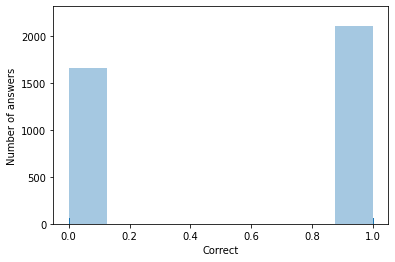

In [3]:
import seaborn as sns
import pandas as pd
data = pd.read_csv( BASE_DIR + "BERT/datasets/dataset_q_ma_sa.csv")
data.drop(columns=["Unnamed: 0"],inplace=True)
ax = sns.distplot(data['correct'],kde=False,rug=True)
ax.set(xlabel='Correct', ylabel='Number of answers')

In [4]:
data.head()

,answer,id,score,correct,questions,target_answers
0,Espacio,1,1.0,0.0,Las frases son piedrecillas que el escritor ar...,El mundo del lector
1,El entendimiento.,1,3.0,0.0,Las frases son piedrecillas que el escritor ar...,El mundo del lector
2,Los sentimientos que tiene una persona en su e...,1,3.5,1.0,Las frases son piedrecillas que el escritor ar...,El mundo del lector
3,El lector,1,3.5,0.0,Las frases son piedrecillas que el escritor ar...,El mundo del lector
4,Corazón,1,2.5,0.0,Las frases son piedrecillas que el escritor ar...,El mundo del lector


In [5]:
data.groupby(["correct","score"]).count()

answer   id  questions  target_answers
correct score                                        
0.0     0.0        59   59         59              59
        1.0       166  166        166             166
        1.5       165  165        165             165
        2.0       326  326        326             326
        2.5       451  451        451             451
        3.0       382  382        382             382
        3.5       106  106        106             106
        4.0         7    7          7               7
1.0     1.0         1    1          1               1
        2.0        18   18         18              18
        2.5       216  216        216             216
        3.0       332  332        332             332
        3.5       636  636        636             636
        4.0       529  529        529             529
        4.5       331  331        331             331
        5.0        47   47         47              47

[Text(0, 0.5, 'Number of answers'), Text(0.5, 0, 'Correctness')]

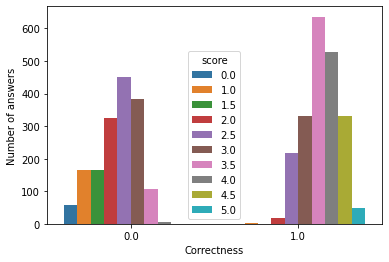

In [6]:
data_correctness = data.groupby(["correct","score"]).count()
g = sns.countplot(
    data=data,
    x="correct", hue="score"
)
g.set(xlabel='Correctness', ylabel='Number of answers')

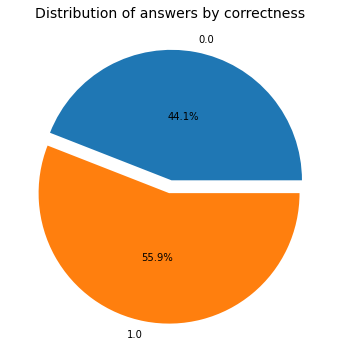

In [7]:
#Using matplotlib
import matplotlib.pyplot as plt
data_count_0_1 = data.groupby("correct")["answer"].count()
pie, ax = plt.subplots(figsize=[10,6])
labels = data_count_0_1.keys()
plt.pie(x=data_count_0_1, autopct="%.1f%%", explode=[0.05]*2, labels=labels, pctdistance=0.5)
plt.title("Distribution of answers by correctness", fontsize=14);
pie.savefig("DistributionAnswersPieCorr.png")

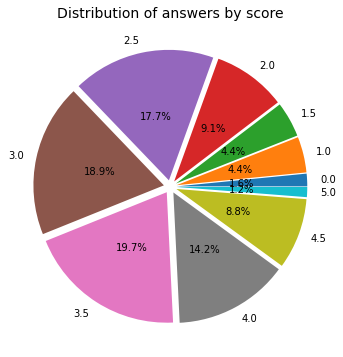

In [8]:
#Using matplotlib
import matplotlib.pyplot as plt
data_count = data.groupby("score")["answer"].count()
pie, ax = plt.subplots(figsize=[10,6])
labels = data_count.keys()
plt.pie(x=data_count, autopct="%.1f%%", explode=[0.05]*10, labels=labels, pctdistance=0.5)
plt.title("Distribution of answers by score", fontsize=14);
pie.savefig("DistributionAnswersPie.png")

# Setup and Preprocessing

In [9]:
import pandas as pd
import numpy as np
import string

data_training = pd.read_csv( BASE_DIR + "BERT/datasets/dataset_q_ma_sa.csv")
data_training.drop(columns=["Unnamed: 0"],inplace=True)
data_training.head()
questions = []
target_answers = []
answers = []
labels = []

for index,row in data_training.iterrows(): # Separate each sentence in different arrays, and remove punctuation
    questions.append(row["questions"].translate(str.maketrans('', '', string.punctuation)).lower())
    target_answers.append(row["target_answers"].translate(str.maketrans('', '', string.punctuation)).lower())
    answers.append(row["answer"].translate(str.maketrans('', '', string.punctuation)).lower())
    labels.append(row["score"])

#print(questions[0:10])
print(target_answers[0:10])
print(answers[0:10])
print(labels[0:10])



['el mundo del lector', 'el mundo del lector', 'el mundo del lector', 'el mundo del lector', 'el mundo del lector', 'el mundo del lector', 'el mundo del lector', 'el mundo del lector', 'el mundo del lector', 'el mundo del lector']
['espacio', 'el entendimiento', 'los sentimientos que tiene una persona en su espíritu', 'el lector', 'corazón', 'la capacidad de compresión de las personas', 'a la capacidad del lector para aprehender lo que lee', 'las personas', 'todo lo que a ti te rodea', 'el alma del lector']
[1.0, 3.0, 3.5, 3.5, 2.5, 3.5, 4.0, 2.5, 3.0, 3.5]


In [ ]:
''' concat_sentences = []

for i in range(0,len(answers)-1):
  concat_sentences.append("{} {}".format(answers[i],target_answers[i]))

concat_sentences[0:10] '''


# Check for GPU availability

In [10]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB



#Bert Tokenization

### BETO (BERT en Español)

In [11]:
from transformers import BertTokenizer
#'bert-base-multilingual-uncased'
tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")

max_len = 0

# For every sentence...
for i in range(0,len(answers)):

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(answers[i],target_answers[i], add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)



Max sentence length:  90


In [12]:
import torch
def preprocessing_for_bert(answers,target_answers):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []
    token_type_ids = []
    # For every sentence...
    for i in range(0,len(answers)):
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_dict = tokenizer.encode_plus(
                        answers[i],
                        target_answers[i],                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        truncation = True,
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        token_type_ids.append(encoded_dict['token_type_ids'])
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.

    return input_ids,token_type_ids, attention_masks


In [13]:
input_ids,token_type_ids, attention_masks = preprocessing_for_bert(answers,target_answers)
input_ids = torch.cat(input_ids, dim=0)
token_type_ids = torch.cat(token_type_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

In [14]:
index = data_training.index.tolist()
tensor_index = torch.tensor(index)

In [ ]:
print(input_ids.type())
print(attention_masks.size())

torch.LongTensor
torch.Size([3772, 90])


In [ ]:
print('Original Answer: ', answers[1])
print('Model Answer: ', target_answers[1])
print('Token IDs:', input_ids[1])
print('Token type IDs:', token_type_ids[1])
print("Label: ",labels[1])

Original Answer:  el entendimiento
Model Answer:  el mundo del lector
Token IDs: tensor([    4,  1039, 10638,     5,  1039,  1758,  1081, 16368,     5,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1])
Token type IDs: tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Datasetloaders for training

In [15]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks,token_type_ids, labels,tensor_index)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_data, val_data = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

3,394 training samples
  378 validation samples


In [ ]:
torch.save(train_data,BASE_DIR + "BERT/datasets/train_dataset_beto_sa_ma_sep.pt")
torch.save(val_data,BASE_DIR + "BERT/datasets/test_dataset_beto_sa_ma_sep.pt")


## Importing datasets for training

In [ ]:
train_data = torch.load(BASE_DIR + "BERT/datasets/train_dataset_beto_sa_ma_sep.pt")
val_data = torch.load(BASE_DIR + "BERT/datasets/test_dataset_beto_sa_ma_sep.pt")

In [16]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_data,  # The training samples.
            sampler = RandomSampler(train_data), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_data, # The validation samples.
            sampler = SequentialSampler(val_data), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Loading Pretrained model

In [17]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased",
                                    num_labels = 1, 
                                    output_attentions = False, # Whether the model returns attentions weights.
                                    output_hidden_states = False)
model.cuda()

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncas

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

In [ ]:
!nvcc --version
!nvidia-smi

#BERT Architecture model

In [ ]:

# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

In [18]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [19]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 15

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [20]:
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from math import sqrt
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = preds.flatten()
    labels_flat = labels.flatten()
    return pearsonr(pred_flat,labels_flat)[0]
def flat_rmse(preds, labels):
    pred_flat = preds.flatten()
    labels_flat = labels.flatten()
    return sqrt(mean_squared_error(pred_flat,labels_flat))

In [ ]:
def weights_init(m):
  torch.nn.init.xavier_uniform(m.weight.data)

In [21]:
global predictions, indexes, labels_test
predictions = np.array([])
indexes = np.array([])
labels_test = np.array([])
def get_predictions(p,l,i):
  global predictions, indexes, labels_test
  predictions = np.concatenate((predictions,p.flatten()),axis=0)
  indexes = np.concatenate((indexes,i.flatten()),axis=0)
  labels_test = np.concatenate((labels_test,l.flatten()), axis=0)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy_classification_task(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [22]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

#Training

In [23]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_type_token_ids = batch[2].to(device)
        b_labels = batch[3].to(device)
        b_index = batch[4].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=b_type_token_ids, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    rmse = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_type_token_ids = batch[2].to(device)
        b_labels = batch[3].to(device)
        b_index = batch[4]
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=b_type_token_ids, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        get_predictions(logits,label_ids,b_index.numpy())
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        rmse += flat_rmse(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_rmse = rmse / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    print("  RMSE: {0:.2f}".format(avg_rmse))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'RMSE': avg_rmse ,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 15 ========
Training...
  Batch    40  of    107.    Elapsed: 0:00:12.
  Batch    80  of    107.    Elapsed: 0:00:24.

  Average training loss: 0.98
  Training epoch took: 0:00:32

Running Validation...
  Accuracy: 0.72
  RMSE: 0.76
  Validation Loss: 0.60
  Validation took: 0:00:01

======== Epoch 2 / 15 ========
Training...


KeyboardInterrupt: ignored

In [ ]:
b_input_mask[0].size()

torch.Size([90])

In [ ]:
predictions.tolist()[-378:]

[3.041292190551758,
 1.644073486328125,
 2.774709939956665,
 3.900918960571289,
 3.130629539489746,
 5.1200480461120605,
 4.754549026489258,
 3.24786114692688,
 3.9102742671966553,
 3.8466224670410156,
 4.2700676918029785,
 2.444305658340454,
 4.419213771820068,
 1.848793387413025,
 2.45747971534729,
 2.8761332035064697,
 2.2350733280181885,
 2.631225824356079,
 4.0564961433410645,
 2.772674560546875,
 2.8751914501190186,
 2.41560959815979,
 3.1817827224731445,
 4.076903820037842,
 3.6318135261535645,
 3.444939136505127,
 3.469090223312378,
 2.072164535522461,
 2.122692584991455,
 2.3361713886260986,
 2.710129499435425,
 3.188218116760254,
 4.267116546630859,
 4.810810565948486,
 3.2366349697113037,
 4.0726189613342285,
 3.608750104904175,
 3.254523754119873,
 3.15200138092041,
 2.5722384452819824,
 3.6841647624969482,
 4.745865821838379,
 1.8127505779266357,
 2.6121206283569336,
 2.6311376094818115,
 1.151132345199585,
 2.154326915740967,
 4.497325420379639,
 2.7239205837249756,
 4.36

In [ ]:
labels_test.tolist()[-378:]

[2.5,
 2.0,
 1.5,
 5.0,
 3.5,
 5.0,
 4.5,
 3.0,
 3.5,
 4.5,
 4.5,
 1.5,
 4.5,
 4.0,
 2.5,
 2.5,
 2.5,
 2.5,
 3.5,
 3.0,
 1.5,
 2.0,
 3.0,
 3.5,
 3.5,
 3.0,
 1.5,
 1.0,
 2.5,
 2.5,
 3.0,
 2.5,
 4.0,
 5.0,
 3.5,
 3.5,
 3.5,
 4.5,
 3.0,
 2.0,
 4.0,
 5.0,
 2.0,
 2.0,
 2.5,
 1.5,
 3.0,
 4.5,
 3.0,
 5.0,
 3.0,
 3.5,
 3.0,
 2.0,
 4.5,
 2.5,
 3.5,
 2.5,
 1.0,
 3.0,
 3.5,
 4.5,
 3.5,
 3.5,
 2.5,
 3.5,
 3.0,
 4.0,
 4.0,
 4.5,
 3.0,
 4.0,
 4.5,
 4.5,
 3.0,
 3.0,
 3.0,
 4.5,
 2.0,
 2.5,
 4.0,
 2.5,
 4.5,
 3.0,
 2.5,
 2.5,
 2.5,
 2.5,
 2.0,
 3.0,
 4.5,
 4.0,
 3.0,
 3.0,
 1.0,
 2.0,
 3.0,
 3.0,
 3.0,
 3.0,
 4.0,
 1.5,
 1.5,
 1.5,
 2.5,
 3.5,
 3.5,
 3.5,
 4.5,
 3.5,
 3.5,
 2.5,
 0.0,
 3.5,
 2.5,
 4.5,
 4.0,
 2.5,
 2.5,
 2.0,
 1.5,
 3.5,
 2.5,
 3.0,
 3.0,
 3.0,
 1.0,
 5.0,
 4.0,
 3.5,
 3.5,
 3.0,
 4.0,
 5.0,
 2.0,
 4.0,
 2.5,
 2.5,
 3.5,
 2.5,
 3.0,
 0.0,
 3.0,
 3.5,
 3.5,
 2.5,
 4.0,
 2.0,
 3.5,
 2.5,
 4.5,
 3.0,
 3.5,
 4.5,
 3.5,
 3.0,
 4.0,
 1.5,
 2.5,
 2.5,
 3.5,
 1.5,
 1.5,
 4.0,
 3.0,
 4.5,
 2.0

In [ ]:
indexes.tolist()[-378:]

[461.0,
 395.0,
 3113.0,
 1375.0,
 2354.0,
 1687.0,
 788.0,
 1214.0,
 82.0,
 3568.0,
 1261.0,
 2380.0,
 1257.0,
 750.0,
 953.0,
 3522.0,
 405.0,
 2080.0,
 948.0,
 1838.0,
 2732.0,
 109.0,
 1403.0,
 362.0,
 867.0,
 1659.0,
 2263.0,
 2315.0,
 956.0,
 454.0,
 1209.0,
 2781.0,
 1254.0,
 2512.0,
 2422.0,
 2121.0,
 2808.0,
 231.0,
 678.0,
 831.0,
 3185.0,
 2199.0,
 2508.0,
 568.0,
 129.0,
 497.0,
 143.0,
 534.0,
 3602.0,
 210.0,
 721.0,
 2714.0,
 2356.0,
 1767.0,
 1724.0,
 1813.0,
 3597.0,
 1978.0,
 396.0,
 2437.0,
 2848.0,
 132.0,
 3289.0,
 2357.0,
 2690.0,
 2837.0,
 1796.0,
 401.0,
 3484.0,
 513.0,
 2893.0,
 102.0,
 2285.0,
 3236.0,
 3235.0,
 1914.0,
 2340.0,
 3446.0,
 598.0,
 2872.0,
 2546.0,
 1564.0,
 2651.0,
 93.0,
 916.0,
 2161.0,
 739.0,
 3079.0,
 39.0,
 3499.0,
 188.0,
 2871.0,
 3252.0,
 3579.0,
 353.0,
 1364.0,
 250.0,
 2057.0,
 3314.0,
 3473.0,
 3112.0,
 3382.0,
 2207.0,
 2825.0,
 1879.0,
 3330.0,
 1382.0,
 3060.0,
 2417.0,
 476.0,
 2168.0,
 1387.0,
 3139.0,
 2783.0,
 3082.0,
 1587

In [ ]:
test_data = data_training.iloc[indexes[-378:]]

# Evaluate on test dataset

In [ ]:
test_data["predicted"] = predictions[-378:]
test_data["test_label"] = labels_test[-378:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
import pandas as pd
test_data = pd.read_csv(BASE_DIR + "test_data_beto_sa_ma.csv")

In [ ]:
test_data["quantized_prediction"] = quantizer(predictions[-378:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
examples = test_data.sample(5)
examples

,Unnamed: 0,answer,id,score,correct,questions,target_answers,predicted,test_label,quantized_prediction
148,2247,Ser una persona benevolente no debe ser entend...,13,3.5,1.0,Benevolencia no quiere decir tolerancia de lo ...,La buena voluntad es deseo de bienestar hacia ...,2.93,3.5,3.0
176,829,La libertad nace del entendimiento.,5,4.0,1.0,La actividad más importante que un ser humano ...,Vale la pena ser humano para aprender a entender.,4.56,4.0,4.5
115,2866,El legado que uno deja es eterno,16,4.5,1.0,"La idea no es vivir para siempre, la idea es c...",El legado de la humanidad está en lo que han m...,4.26,4.5,4.5
219,1963,Cuestionar nuestro alrededor,11,4.0,1.0,La duda es uno de los nombres de la inteligenc...,La inteligencia se basa en la capacidad de cue...,4.09,4.0,4.0
116,3146,Las relaciones se construyen con comunicación,17,4.0,1.0,"Las palabras acercan, los silencios destruyen....",La conversación permite el entendimiento de la...,4.06,4.0,4.0


In [ ]:
html_data = pd.DataFrame(data=[],columns=["id","Answer","Actual Score","Predicted Score","Quantized"])

In [ ]:
html_data["id"] = examples["id"]
html_data["Answer"] = examples["answer"]
html_data["Actual Score"] = examples["score"]
html_data["Predicted Score"] = examples["predicted"]
html_data["Quantized"] = examples["quantized_prediction"]

In [ ]:
html_data

,id,Answer,Actual Score,Predicted Score,Quantized
148,13,Ser una persona benevolente no debe ser entend...,3.5,2.93,3.0
176,5,La libertad nace del entendimiento.,4.0,4.56,4.5
115,16,El legado que uno deja es eterno,4.5,4.26,4.5
219,11,Cuestionar nuestro alrededor,4.0,4.09,4.0
116,17,Las relaciones se construyen con comunicación,4.0,4.06,4.0


In [ ]:
from IPython.display import display, HTML

# Assuming that dataframes df1 and df2 are already defined:
display(HTML(html_data.to_html()))

,id,Answer,Actual Score,Predicted Score,Quantized
148,13,"Ser una persona benevolente no debe ser entendida como ser una persona mediocre y que acepte incluso lo malo, por el contraro debe ser una persona recta y capaz de juzgar lo bueno y lo malo",3.5,2.93,3.0
176,5,La libertad nace del entendimiento.,4.0,4.56,4.5
115,16,El legado que uno deja es eterno,4.5,4.26,4.5
219,11,Cuestionar nuestro alrededor,4.0,4.09,4.0
116,17,Las relaciones se construyen con comunicación,4.0,4.06,4.0


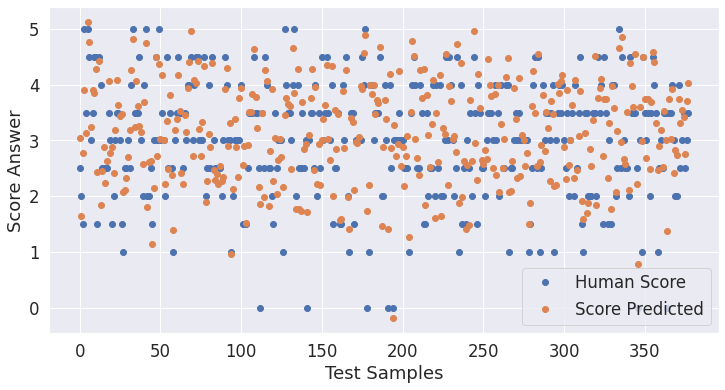

In [ ]:
n = np.arange(len(predictions[-378:]))
plt.figure()
plt.plot(n,labels_test[-378:],'o',label='Human Score') #Grafica de comparación entre human score y score predicted
plt.plot(n,predictions[-378:],'o',label='Score Predicted')
plt.legend(loc='lower right')
plt.xlabel('Test Samples')
plt.ylabel('Score Answer')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


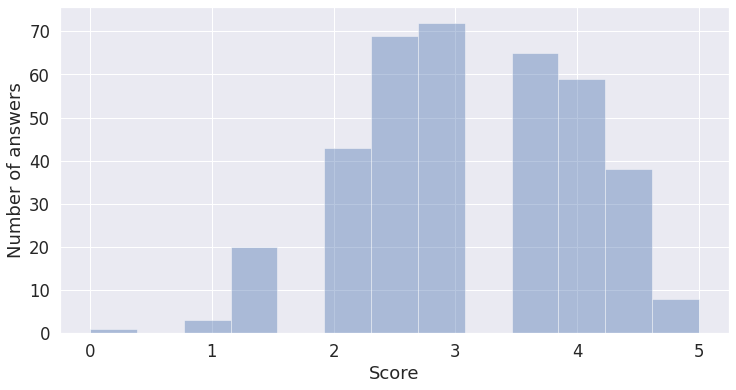

In [ ]:
import seaborn as sns
ax1 = sns.distplot(quantizer(predictions[-378:]), kde=False)
ax1.set(xlabel='Score', ylabel='Number of answers')
plt.show()


In [ ]:
y_pred = predictions[-378:]

In [ ]:
fix_pred = np.where(y_pred>5.0,5.0,y_pred) # Se ajusta la regresión a los valores máximos 0-5 si exceden
fix_pred = np.where(fix_pred<0.0,0.0,fix_pred) 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


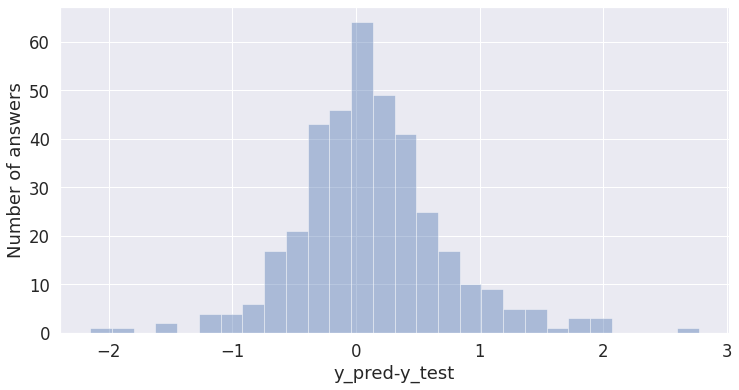

In [ ]:
diferencia = pd.DataFrame({'y_pred-y_test':fix_pred-labels_test[-378:]})
ax2 = sns.distplot(diferencia['y_pred-y_test'], kde=False)
ax2.set(ylabel='Number of answers')
plt.show()

In [ ]:
diferencia_sinquantizer = pd.DataFrame({'y_pred-y_test':predictions[-378:]-labels_test[-378:]})

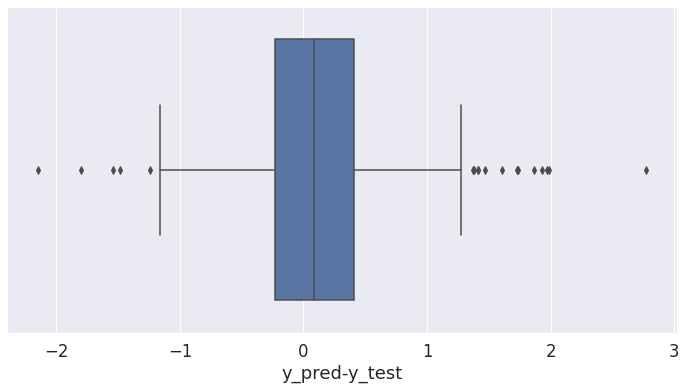

In [ ]:
ax = sns.boxplot(x=diferencia_sinquantizer['y_pred-y_test'])

In [ ]:
test_data.to_csv(BASE_DIR + "test_data_beto_sa_ma.csv")

Text(0, 0.5, 'Actual Score')

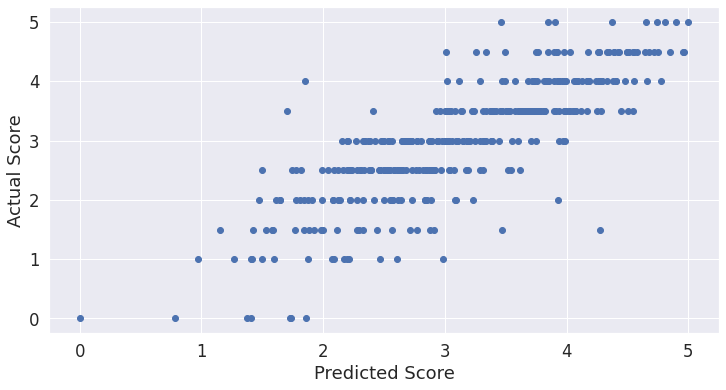

In [ ]:
plt.figure()
plt.plot(fix_pred,labels_test[-378:],'o') 
plt.xlabel('Predicted Score')
plt.ylabel('Actual Score')

Text(0, 0.5, 'Actual Score')

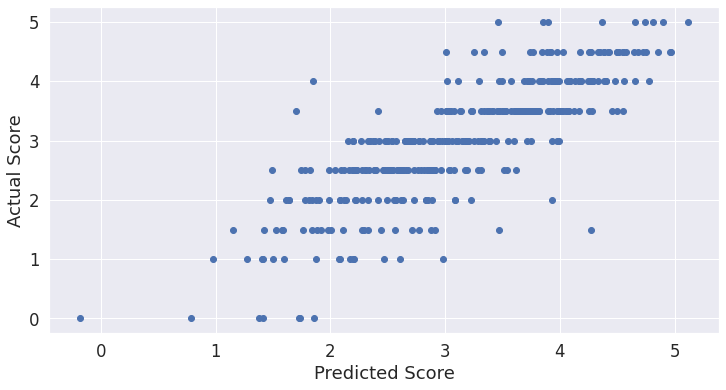

In [ ]:
plt.figure()
plt.plot(predictions[-378:],labels_test[-378:],'o') 
plt.xlabel('Predicted Score')
plt.ylabel('Actual Score')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


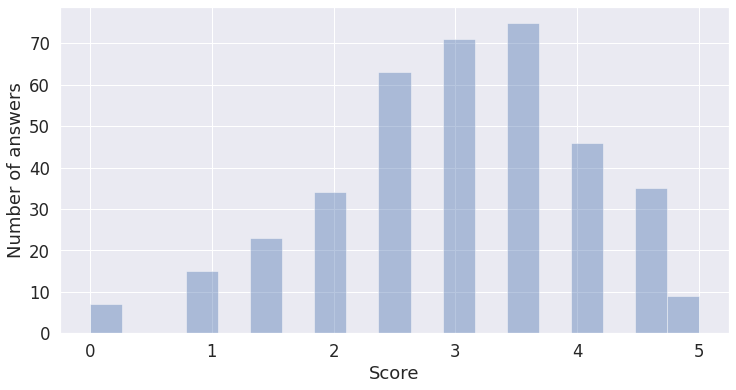

In [ ]:
import seaborn as sns
ax1 = sns.distplot(labels_test[-378:], kde=False)
ax1.set(xlabel='Score', ylabel='Number of answers')
plt.show()

In [ ]:
np.save(BASE_DIR + "BERT/datasets/predictions.npy",predictions[-378:])
np.save(BASE_DIR + "BERT/datasets/labels_test.npy",labels_test[-378:])
np.save(BASE_DIR + "BERT/datasets/indexes.npy",indexes[-378:])

# Training Summary

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,RMSE,Training Time,Validation Time
epoch,,,,,,
1,1.12,0.59,0.70,0.76,0:00:31,0:00:01
2,0.43,0.45,0.78,0.66,0:00:31,0:00:01
3,0.29,0.44,0.78,0.65,0:00:31,0:00:01
4,0.21,0.52,0.78,0.70,0:00:31,0:00:01
5,0.15,0.40,0.80,0.62,0:00:31,0:00:01
6,0.13,0.40,0.81,0.62,0:00:31,0:00:01
7,0.10,0.38,0.81,0.61,0:00:31,0:00:01
8,0.09,0.39,0.82,0.62,0:00:31,0:00:01
9,0.07,0.37,0.82,0.60,0:00:31,0:00:01


# Loss

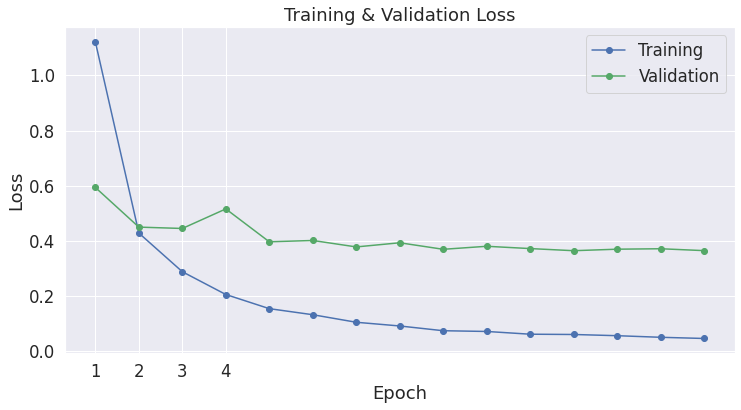

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

#Saving the model

In [ ]:
PATH = "bert_beto_spanish.pt"

# Save
torch.save(model.state_dict(), PATH)

# Load
#model = Net()
#model.load_state_dict(torch.load(PATH))
#model.eval()

In [ ]:
!nvidia-smi --gpu-reset

GPU 00000000:00:04.0 is currently in use by another process.

1 device is currently being used by one or more other processes (e.g., Fabric Manager, CUDA application, graphics application such as an X server, or a monitoring application such as another instance of nvidia-smi). Please first kill all processes using this device and all compute applications running in the system.


# ONNX Exporting

In [ ]:
input_ids_model = torch.unsqueeze(b_input_ids[0], 0)
input_mask_model = torch.unsqueeze(b_input_mask[0],0)
token_type_ids_model = torch.unsqueeze(b_type_token_ids[0],0)

In [ ]:
example_input
example_input.size()

torch.Size([1, 102])

In [ ]:
#example_input= example_input
#example_input1 = example_input1.to(device)


input_names = ["input_ids","attention_mask","token_type_ids"]

output_names = [ "score_prediction" ]

torch.onnx.export(model,(input_ids_model,input_mask_model,token_type_ids_model), "asag_model_beto_spanish_ma_sa_sep.onnx", verbose=True, input_names=input_names, output_names=output_names)

graph(%input_ids : Long(1, 90, strides=[90, 1], requires_grad=0, device=cuda:0),
      %attention_mask : Long(1, 90, strides=[90, 1], requires_grad=0, device=cuda:0),
      %token_type_ids : Long(1, 90, strides=[90, 1], requires_grad=0, device=cuda:0),
      %bert.embeddings.word_embeddings.weight : Float(31002, 768, strides=[768, 1], requires_grad=1, device=cuda:0),
      %bert.embeddings.position_embeddings.weight : Float(512, 768, strides=[768, 1], requires_grad=1, device=cuda:0),
      %bert.embeddings.token_type_embeddings.weight : Float(2, 768, strides=[768, 1], requires_grad=1, device=cuda:0),
      %bert.embeddings.LayerNorm.weight : Float(768, strides=[1], requires_grad=1, device=cuda:0),
      %bert.embeddings.LayerNorm.bias : Float(768, strides=[1], requires_grad=1, device=cuda:0),
      %bert.encoder.layer.0.attention.self.query.bias : Float(768, strides=[1], requires_grad=1, device=cuda:0),
      %bert.encoder.layer.0.attention.self.key.bias : Float(768, strides=[1], requi

In [ ]:
def quantizer(pred):
  output = []
  for sample in pred:
    if abs(sample-5)<0.25:
      output.append(5.0)
    elif abs(sample-4.5)<0.25:
      output.append(4.5)
    elif abs(sample-4.0)<0.25:
      output.append(4.0)
    elif abs(sample-3.5)<0.25:
      output.append(3.5)
    elif abs(sample-3.0)<0.25:
      output.append(3.0)
    elif abs(sample-2.5)<0.25:
      output.append(2.5)
    elif abs(sample-2.0)<0.25:
      output.append(2.0)
    elif abs(sample-1.5)<0.25:
      output.append(1.5)
    elif abs(sample-1.0)<0.25:
      output.append(1.0)
    elif abs(sample-0.5)<0.25:
      output.append(0.5)
    elif abs(sample-0.0)<0.25:
      output.append(0.0)
    elif abs(sample-5)>0.25:
      output.append(5.0)
    elif abs(sample-0)>0.25:
      output.append(0.0)
  return output